<a href="https://colab.research.google.com/github/yashuvishnalia/tensorflow-basic-test-code/blob/master/colab_test2_nifty_P_PCT_V_BF_1_1_5_3_10_6_30_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import os
os.listdir('/content/gdrive/My Drive/Colab Notebooks/')

['Copy of first_steps_with_tensor_flow.ipynb',
 'Untitled0.ipynb',
 'colab_test0_nifty.ipynb',
 'modified_intraday_2017_niftyAllData4-10.pkl',
 'colab_test1_nifty.ipynb',
 'colab_test2_nifty_P_PCT_V.ipynb',
 'Copy of colab_test2_nifty_P_PCT_V.ipynb']

In [2]:
from __future__ import print_function
import pandas as pd

print(pd.__version__)

panel = pd.read_pickle(r'/content/gdrive/My Drive/Colab Notebooks/\
modified_intraday_2017_niftyAllData4-10.pkl')#,parse_dates=[1])#,date_parser=True)#index_col=False)--not working
panel

0.23.4


<class 'pandas.core.panel.Panel'>
Dimensions: 101 (items) x 89280 (major_axis) x 5 (minor_axis)
Items axis: ACC to ZEEL
Major_axis axis: 2017-01-02 04:01:00+00:00 to 2017-12-29 10:00:00+00:00
Minor_axis axis: open to volume

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM,Dense, Activation,Dropout

# For custom metrics
import keras.backend as K

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import preprocessing

Using TensorFlow backend.


In [4]:
scaler=preprocessing.MinMaxScaler()
panel['HINDUNILVR'].head()

,open,high,low,close,volume
2017-01-02 04:01:00+00:00,823.60,823.80,823.25,823.75,1699.0
2017-01-02 04:02:00+00:00,824.35,825.50,824.30,824.65,365.0
2017-01-02 04:03:00+00:00,825.00,825.65,824.80,825.05,324.0
2017-01-02 04:04:00+00:00,824.90,825.00,824.30,824.45,564.0
2017-01-02 04:05:00+00:00,824.50,825.60,824.50,825.60,385.0


In [0]:
# callbacks = [
#   # Interrupt training if `val_loss` stops improving for over 2 epochs
#   tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#   # Write TensorBoard logs to `./logs` directory
#   tf.keras.callbacks.TensorBoard(log_dir='./logs')
# ]


In [0]:
def train(df,batch_size=32,back_step=1,forward=1):
  df['PCT_change']=((df['close']-df['open'])/df['open'])*100
  df['HL_PCT']= ((df['high']-df['low'])/df['close'])*100
  df_=df[['close','volume','PCT_change','HL_PCT']]
  df_['pct']=df['close'].pct_change()
  new_order = [0,4,1,2,3]
  df_=df_[df_.columns[new_order]]
  df_.fillna(0,inplace=True)
  print(df_.head())

  data_=np.array(df_)[0:10000]#change no. of data examples

  global scaler
  scaler=scaler.fit(data_)
  data = scaler.transform(data_)
  mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True,verbose=1)
  early_stop = keras.callbacks.EarlyStopping(monitor='loss',mode='min', verbose=1,patience=50)#,baseline=4.2307e-04,#monitor='val_loss'
# could use early_stop and mc in a list(it will save best model and stop after patience=50)
  callbacks=[early_stop,mc]
  
  def feature_and_label(X,y,back_step=1,forward_step=1):
      X_ = np.array([X[i:i+back_step][:] for i in range(len(X)-back_step+1-forward_step)])#index(0-1009)=len1010
      #for continuous data prediction
  #     y_ = np.array([y[i+back_step:i+back_step+forward_step] 
  #                    for i in range(len(y)-back_step+1-forward_step)])#index(1-1010)=len1010
      #prediction at forward_step 
      y_ = np.array([y[i+back_step+forward_step-1] 
                     for i in range(len(y)-back_step+1-forward_step)])    
      return X_,y_
  def data_prep(data_t,back_step=1,forward=1,batch_size=32):
      ''' change data_t[:,1:2],data_t[:,0] accordingly '''
      X_,y_ = feature_and_label(data_t[:,0:3],data_t[:,0],back_step,forward)
      X_=X_.reshape(len(X_),len(X_[0]),len(X_[0][0]))
      y_=y_.reshape(len(y_),1)#have to change if we have other dimen of y
      print("shape X, y : ",X_.shape,y_.shape,X_[0],y_[0])

      m=int(len(X_)/batch_size)
      ratio=(int(m*0.8))*batch_size
      train_X,test_X=X_[:ratio],X_[ratio:m*batch_size]
      train_y,test_y=y_[:ratio],y_[ratio:m*batch_size]
      print("test x,y and train x, y shape : ",test_X.shape,test_y.shape,train_X.shape,train_y.shape)

      return train_X,train_y,test_X,test_y

  train_X,train_y,test_X,test_y = \
  data_prep(data_t=data,back_step=back_step,forward=1,batch_size=batch_size)
  
  def build_neural_net(batch_size,back_step=1,n_feature=1):
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True,batch_input_shape=(batch_size,back_step, n_feature),
                   stateful=True,))  # returns a sequence of vectors of dimension 32
    model.add(Dropout(0.1))
    model.add(LSTM(256))#, return_sequences=True, stateful=True,))  # returns a sequence of vectors of dimension 32
#     model.add(LSTM())  # return a single vector of dimension 32
    model.add(Dropout(0.1))
    model.add(Dense(64))
    model.add(Dense(1))
#     def mean_pred(y_true, y_pred):
#         return K.mean(y_pred)

    # For a mean squared error regression problem
    model.compile(optimizer='adam',
                  loss='mse',
                 metrics=['mae'])# accuracy for regression model doesn't matter
    return model
  def train_(train_X,train_y,back_step,n_feature=1,batch_size=32,model=False):
      if not model:
          model = build_neural_net(batch_size,back_step,n_feature)
      model.fit(train_X,train_y,
            batch_size=batch_size, epochs=85, shuffle=False, verbose=0,
                      callbacks=callbacks,
  #           validation_data=(x_val, y_val)
               )
      return model
  model = train_(train_X,train_y,back_step,n_feature=3,batch_size=batch_size)
  return model,train_X,train_y,test_X,test_y

In [0]:
def plot_graph(model,pred,test_y,best_model_bool=False):
  '''
  this function will return df_yp(200min) DataFrame
  '''
  global scaler
  global ticker
  def scale_for_c_price(scaler=scaler):
      scale=preprocessing.MinMaxScaler()
      scale.min_,scale.scale_=scaler.min_[0],scaler.scale_[0]
      return scale
  scale = scale_for_c_price()
  p=scale.inverse_transform(pred)
  y=scale.inverse_transform(test_y)
  def price_plot(p=p,y=y,ticker=ticker):
      plt.figure(figsize=(15,4))
      plt.plot(range(len(pred)),p,label='p')
      plt.plot(range(len(test_y)),y,label='y')
      plt.title('model for 3 feature(p,pct,v) and 100 epoch for {}'.format(ticker))
      plt.ylabel('price')
      plt.xlabel('minute')
      plt.grid()
      plt.legend()
      plt.show()
      return p,y
  p=p[:200].reshape(-1)
  y=y[:200].reshape(-1)
  df_yp=pd.DataFrame({'p':p,'y':y})
  df_yp['diff']=df_yp['y']-df_yp['p']
  def loss_plot(model=model):
    model_dict = model.history.history
    np_loss=np.array(model_dict['loss'])
    np_loss = np.sqrt(np_loss)
    plt.plot(np_loss)
    plt.ylabel('rmse loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show()
    print('minumum loss: {} '.format(np.amin(np_loss)))
    print('at epoch : {}'.format(np.where(np_loss==np.amin(np_loss))))
  if not best_model_bool:
    print("plot for error vs epoch")
    loss_plot()
    print("df_yp.describe for initial 200 minute test data")
    print(df_yp.describe())
  def diff_plot(df_yp=df_yp):
    plt.figure(figsize=(15,5))
    plt.title('graph for first 200 minutes')
    ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
    ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)

    ax1.plot(df_yp.index,df_yp.y,label='y')
    ax1.plot(df_yp.index,df_yp.p,label='p')
    ax2.bar(df_yp.index,df_yp['diff'])
    ax2.yaxis.set_ticks([-5,-3,-2,-1,0,1,2,3,5])
    ax1.grid()
    ax2.grid()
    ax2.set_xlabel('time (m)')
    ax2.set_ylabel('Error')
    ax1.legend()
    plt.show()
  if best_model_bool:
    price_plot()
    diff_plot()
  return df_yp

In [7]:
ticker='INFY'
df=panel[ticker]
# df['date'] = pd.to_datetime(df['date'],utc=True)
# df.set_index('date',inplace=True)
df.head(3)#,df.index.dtype

,open,high,low,close,volume
2017-01-02 04:01:00+00:00,1005.25,1006.35,1005.20,1005.4,2517.0
2017-01-02 04:02:00+00:00,1005.65,1006.65,1005.55,1005.6,2523.0
2017-01-02 04:03:00+00:00,1005.65,1006.90,1005.25,1006.9,1850.0


In [28]:
model,train_X,train_y,test_X,test_y=train(df,batch_size=64,back_step=30,forward=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


                            close       pct  volume  PCT_change    HL_PCT
2017-01-02 04:01:00+00:00  1005.4  0.000000  2517.0    0.014922  0.114382
2017-01-02 04:02:00+00:00  1005.6  0.000199  2523.0   -0.004972  0.109387
2017-01-02 04:03:00+00:00  1006.9  0.001293  1850.0    0.124298  0.163869
2017-01-02 04:04:00+00:00  1007.3  0.000397  2512.0    0.029791  0.079420
2017-01-02 04:05:00+00:00  1007.7  0.000397  1964.0    0.019851  0.099236
shape X, y :  (9970, 30, 3) (9970, 1) [[9.60538980e-01 4.63625749e-01 4.05893290e-03]
 [9.62463908e-01 4.68414346e-01 4.06893849e-03]
 [9.74975938e-01 4.94745440e-01 2.94664521e-03]
 [9.78825794e-01 4.73188676e-01 4.05059492e-03]
 [9.82675650e-01 4.73184879e-01 3.13675135e-03]
 [9.75938402e-01 4.46903913e-01 4.60757256e-03]
 [9.71607315e-01 4.52868525e-01 5.35465635e-03]
 [9.75938402e-01 4.74387783e-01 4.01891056e-03]
 [9.74013474e-01 4.58844760e-01 1.93274578e-03]
 [9.74013474e-01 4.63625749e-01 5.16455021e-03]
 [9.69682387e-01 4.52866388e-01 5.9499

In [0]:
# Save entire model to a HDF5 file
model.save('my_model.h5')

# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('my_model.h5')

In [0]:
model

In [9]:
batch_size=64
pred = model.predict(test_X, batch_size=batch_size)
loss_and_metrics = model.evaluate(test_X,test_y, batch_size=batch_size)
loss_and_metrics

2048/2048 [==============================] - 1s 275us/sample - loss: 1.6881e-04 - mean_absolute_error: 0.0113


[0.0001688063589426747, 0.011349236]

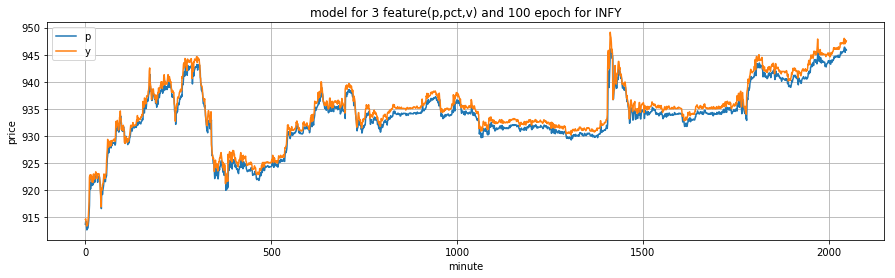

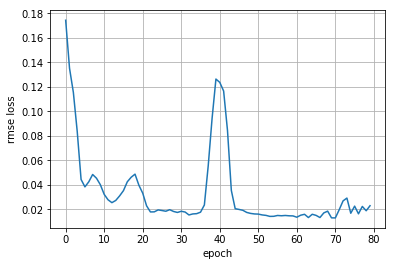

minumum loss: 0.01304025473480293 
at epoch : (array([70]),)
                p           y        diff
count  200.000000  200.000000  200.000000
mean   928.781433  929.517500    0.736235
std      6.664388    6.648876    0.910258
min    912.603821  913.350000   -2.026050
25%    922.420135  923.000000    0.281146
50%    930.675537  931.100000    0.656769
75%    932.935822  933.637500    1.125699
max    941.324097  942.550000    5.230920


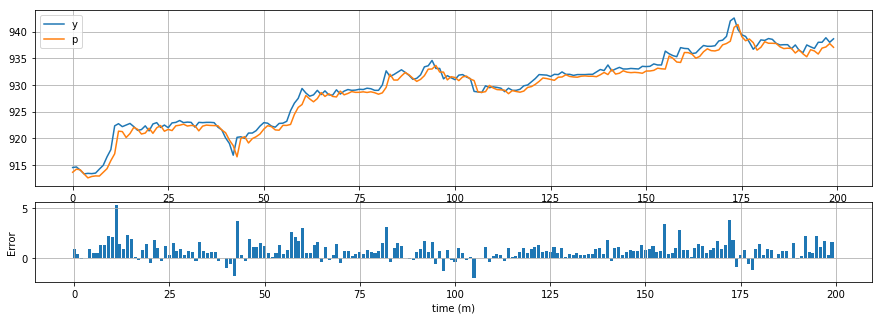

In [10]:
'''epoch = 80 
feature = price,pct,vol
back_step=1,f_step=1
'''
df_yp=plot_graph(model,pred,test_y)

In [0]:
'''
where did the best_model.h5 file got saved
'''

'\nwhere did the best_model.h5 file got saved\n'

In [11]:
best_model = tf.keras.models.load_model('best_model.h5')
batch_size=64
pred = best_model.predict(test_X, batch_size=batch_size)
loss_and_metrics = best_model.evaluate(test_X,test_y, batch_size=batch_size)
loss_and_metrics

2048/2048 [==============================] - 1s 270us/sample - loss: 6.7707e-05 - mean_absolute_error: 0.0056


[6.7706894441244e-05, 0.005640482]

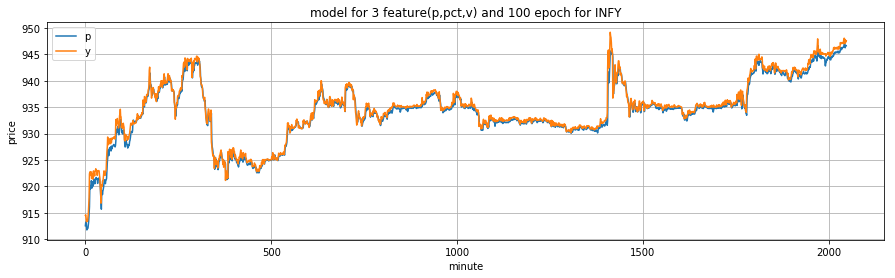

                p           y        diff
count  200.000000  200.000000  200.000000
mean   928.373596  929.517500    1.143958
std      7.207238    6.648876    1.137135
min    911.794434  913.350000   -1.853101
25%    921.427765  923.000000    0.220502
50%    929.777100  931.100000    1.161572
75%    933.282364  933.637500    1.878378
max    941.445496  942.550000    6.189905


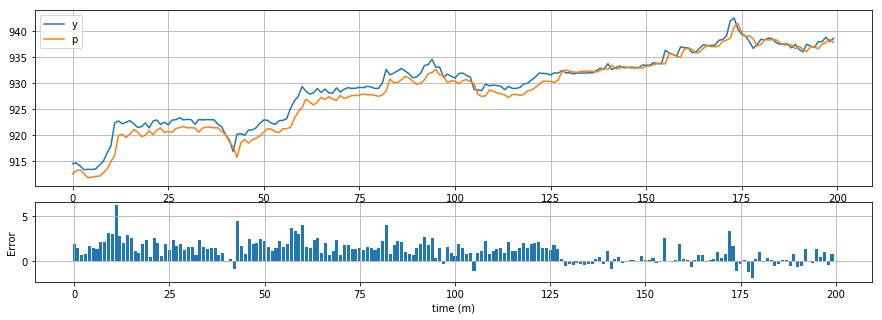

In [12]:
df_yp=plot_graph(best_model,pred,test_y,best_model_bool=True)

In [14]:
from scipy import stats
print(stats.describe(test_y))
print(stats.describe(pred))
data={'test_y':list(test_y.reshape(-1)),'pred':list(pred.reshape(-1))}
df_test = pd.DataFrame(data)
print(df_test.describe())

DescribeResult(nobs=2048, minmax=(array([0.07459095]), array([0.41915303])), mean=array([0.27946065]), variance=array([0.00307809]), skewness=array([-0.23130148]), kurtosis=array([0.45973512]))
DescribeResult(nobs=2048, minmax=(array([0.05962024], dtype=float32), array([0.39863524], dtype=float32)), mean=array([0.2748106], dtype=float32), variance=array([0.00307975], dtype=float32), skewness=array([-0.4245756], dtype=float32), kurtosis=array([0.70889735], dtype=float32))
            test_y         pred
count  2048.000000  2048.000000
mean      0.279461     0.274811
std       0.055481     0.055495
min       0.074591     0.059620
25%       0.253609     0.250172
50%       0.283446     0.279804
75%       0.307026     0.303268
max       0.419153     0.398635


In [13]:
# mse, _ = model.evaluate(test_X,test_y, batch_size=batch_size)
rmse = np.sqrt(loss_and_metrics[0])
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

Root Mean Square Error on test set: 0.008


In [0]:
'''===================================================end of session===================================================='''
'''================================below is for back_step=5,forward_step=3============================='''

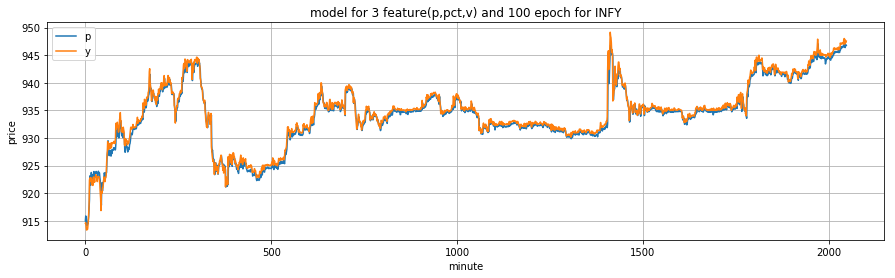

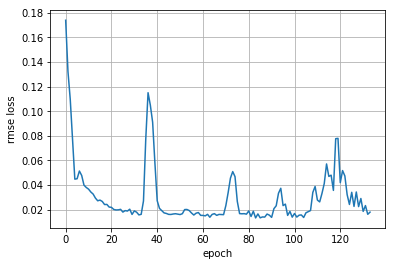

minumum loss: 0.013270818090899058 
at epoch : (array([83]),)
                p           y        diff
count  200.000000  200.000000  200.000000
mean   929.104248  929.517500    0.413138
std      6.211472    6.648876    1.103090
min    914.056580  913.350000   -2.971106
25%    923.712646  923.000000   -0.266086
50%    929.999329  931.100000    0.457880
75%    933.131760  933.637500    1.116260
max    941.510071  942.550000    3.734656


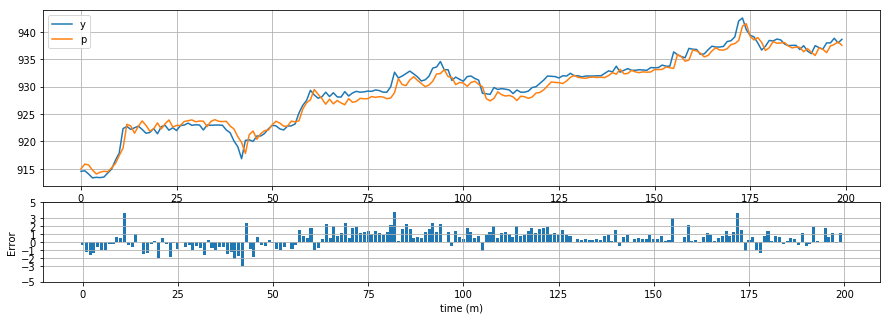

================================below best_model_graph is for back_step=5,forward_step=3=============================
2048/2048 [==============================] - 1s 412us/sample - loss: 6.2475e-05 - mean_absolute_error: 0.0056
[6.247498220091074e-05, 0.005605211]


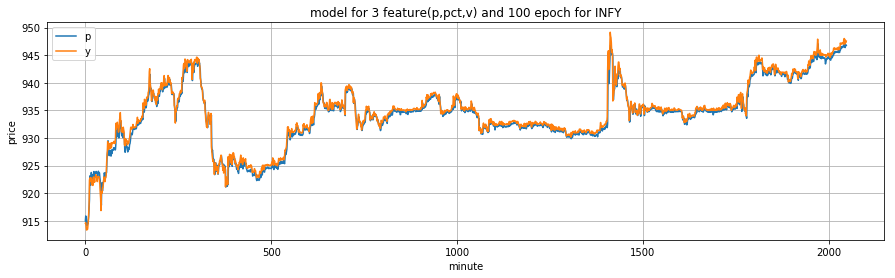

                p           y        diff
count  200.000000  200.000000  200.000000
mean   929.104248  929.517500    0.413138
std      6.211472    6.648876    1.103090
min    914.056580  913.350000   -2.971106
25%    923.712646  923.000000   -0.266086
50%    929.999329  931.100000    0.457880
75%    933.131760  933.637500    1.116260
max    941.510071  942.550000    3.734656


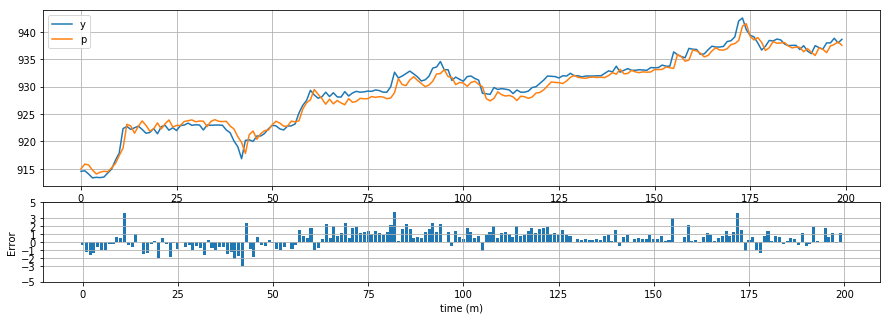

Root Mean Square Error on test set: 0.008


In [23]:
_=plot_graph(model,pred,test_y)
print('====================================================================================================================')
print('================================below best_model_graph is for back_step=5,forward_step=3=============================')
best_model = tf.keras.models.load_model('best_model.h5')
batch_size=64
pred = best_model.predict(test_X, batch_size=batch_size)
loss_and_metrics = best_model.evaluate(test_X,test_y, batch_size=batch_size)
print(loss_and_metrics)
_=plot_graph(best_model,pred,test_y,best_model_bool=True)
rmse = np.sqrt(loss_and_metrics[0])
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

In [0]:
'''===================================================end of session===================================================='''
'''================================below is for back_step=10,forward_step=6============================='''

plot for error vs epoch


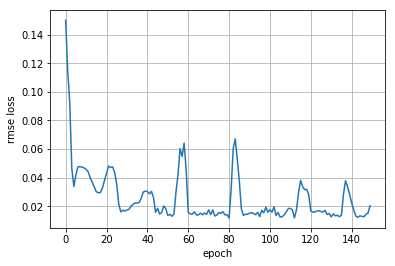

minumum loss: 0.011814929872186535 
at epoch : (array([112]),)
df_yp.describe for initial 200 minute test data
                p           y        diff
count  200.000000  200.000000  200.000000
mean   929.104248  930.149000    1.044638
std      6.211472    6.336498    2.135002
min    914.056580  913.400000   -6.785010
25%    923.712646  923.162500   -0.104324
50%    929.999329  931.425000    0.929022
75%    933.131760  934.775000    2.013516
max    941.510071  942.550000    8.283752
================================below best_model_graph is for back_step=10,forward_step=6=============================
2048/2048 [==============================] - 1s 589us/sample - loss: 4.6407e-05 - mean_absolute_error: 0.0045
[4.640693218505021e-05, 0.004453087]


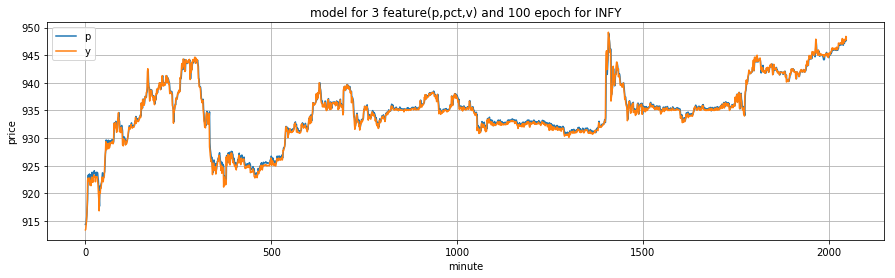

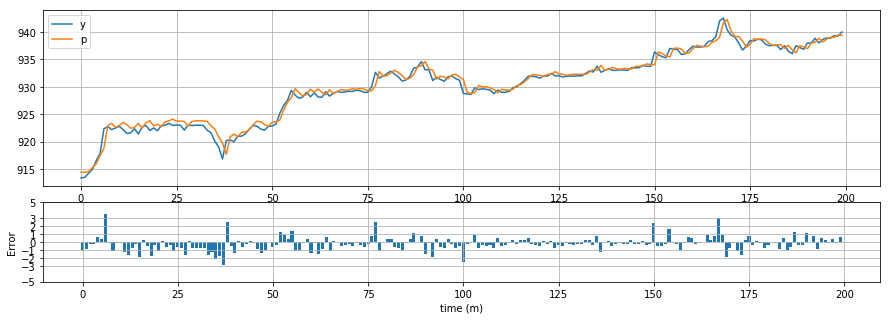

Root Mean Square Error on test set: 0.007


In [26]:
_=plot_graph(model,pred,test_y)
print('====================================================================================================================')
print('================================below best_model_graph is for back_step=10,forward_step=6=============================')
best_model = tf.keras.models.load_model('best_model.h5')
batch_size=64
pred = best_model.predict(test_X, batch_size=batch_size)
loss_and_metrics = best_model.evaluate(test_X,test_y, batch_size=batch_size)
print(loss_and_metrics)
_=plot_graph(best_model,pred,test_y,best_model_bool=True)
rmse = np.sqrt(loss_and_metrics[0])
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

In [0]:
print('====================================================================================================================')
print('================================below best_model_graph is for back_step=30,forward_step=10=============================')
print('it took 1hr to finish this simulation')

plot for error vs epoch


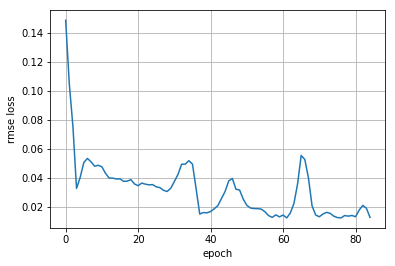

minumum loss: 0.01224464724313306 
at epoch : (array([76]),)
df_yp.describe for initial 200 minute test data
                p           y        diff
count  200.000000  200.000000  200.000000
mean   930.404785  932.144750    1.740026
std      6.136855    5.900491    3.149781
min    914.407288  916.850000   -6.619849
25%    923.826675  929.000000   -0.309088
50%    931.668396  932.000000    1.761523
75%    934.304855  937.400000    3.484842
max    942.270874  942.550000   10.472693
================================below best_model_graph is for back_step=30,forward_step=10=============================
1984/1984 [==============================] - 3s 1ms/sample - loss: 5.9279e-05 - mean_absolute_error: 0.0056
[5.9279418564983644e-05, 0.0055533675]


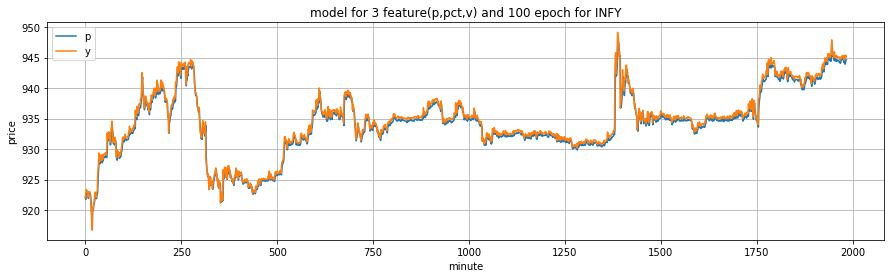

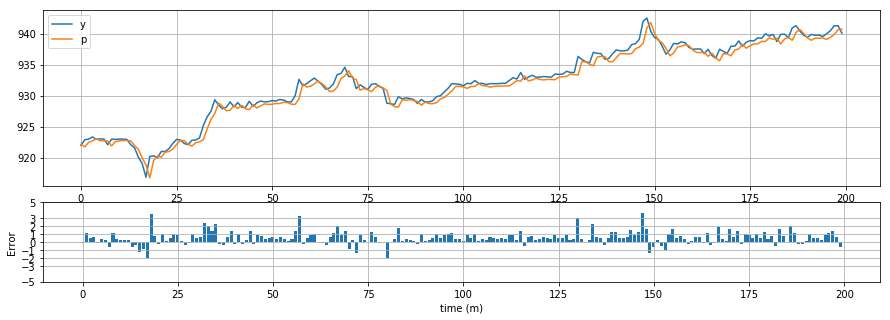

Root Mean Square Error on test set: 0.008


In [29]:
_=plot_graph(model,pred,test_y)
print('====================================================================================================================')
print('================================below best_model_graph is for back_step=30,forward_step=10=============================')
best_model = tf.keras.models.load_model('best_model.h5')
batch_size=64
pred = best_model.predict(test_X, batch_size=batch_size)
loss_and_metrics = best_model.evaluate(test_X,test_y, batch_size=batch_size)
print(loss_and_metrics)
_=plot_graph(best_model,pred,test_y,best_model_bool=True)
rmse = np.sqrt(loss_and_metrics[0])
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))